# clinical application - 1

locating intracranial electrode contacts

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import nilearn.plotting
from dipy.align import resample

import mne
from mne.datasets import fetch_fsaverage

# paths to mne datasets: sample sEEG and FreeSurfer's fsaverage subject,
# which is in MNI space
misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = sample_path / 'subjects'

# use mne-python's fsaverage data
fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # downloads if needed

# GUI requires pyvista backend
mne.viz.set_3d_backend('pyvistaqt')

0 files missing from root.txt in /Users/DanDan/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/DanDan/mne_data/MNE-sample-data/subjects/fsaverage
Using pyvistaqt 3d backend.



Aligning the T1 to ACPC

Text(246, 75, 'AC')

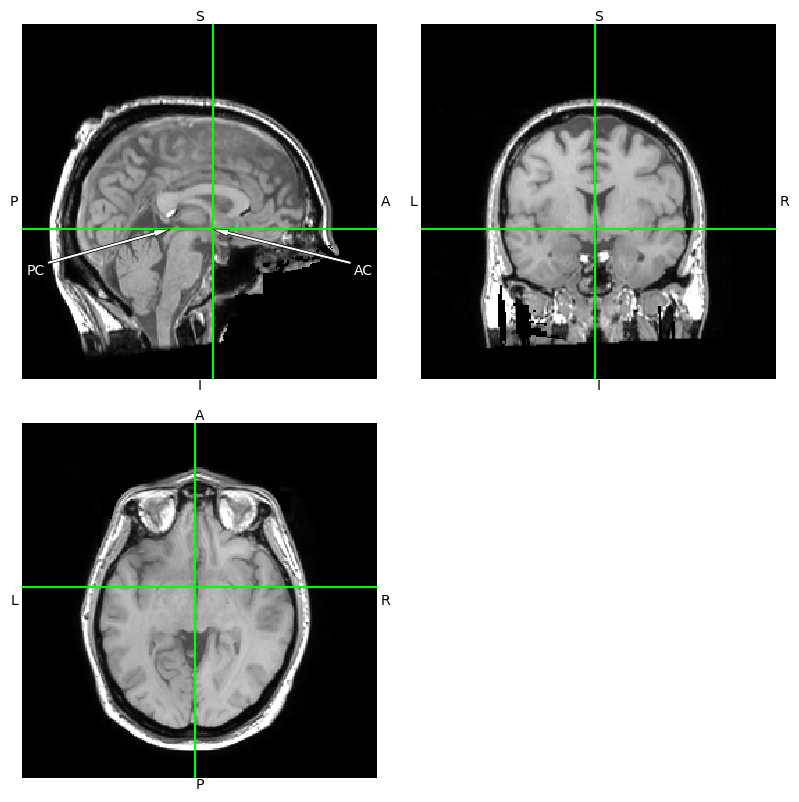

In [5]:
T1 = nib.load(misc_path / 'seeg' / 'sample_seeg' / 'mri' / 'T1.mgz')
viewer = T1.orthoview()
viewer.set_position(0, 9.9, 5.8)
viewer.figs[0].axes[0].annotate(
    'PC', (107, 108), xytext=(10, 75), color='white',
    horizontalalignment='center',
    arrowprops=dict(facecolor='white', lw=0.5, width=2, headwidth=5))
viewer.figs[0].axes[0].annotate(
    'AC', (137, 108), xytext=(246, 75), color='white',
    horizontalalignment='center',
    arrowprops=dict(facecolor='white', lw=0.5, width=2, headwidth=5))

Aliniging the CT to the MR

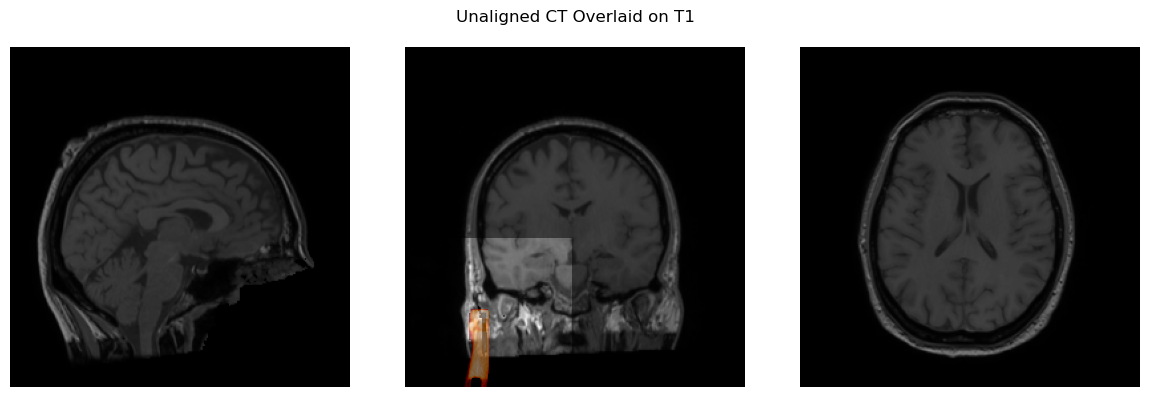

In [6]:
def plot_overlay(image, compare, title, thresh=None):
    """Define a helper function for comparing plots."""
    image = nib.orientations.apply_orientation(
        np.asarray(image.dataobj), nib.orientations.axcodes2ornt(
            nib.orientations.aff2axcodes(image.affine))).astype(np.float32)
    compare = nib.orientations.apply_orientation(
        np.asarray(compare.dataobj), nib.orientations.axcodes2ornt(
            nib.orientations.aff2axcodes(compare.affine))).astype(np.float32)
    if thresh is not None:
        compare[compare < np.quantile(compare, thresh)] = np.nan
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(np.take(image, [image.shape[i] // 2], axis=i).squeeze().T,
                  cmap='gray')
        ax.imshow(np.take(compare, [compare.shape[i] // 2],
                          axis=i).squeeze().T, cmap='gist_heat', alpha=0.5)
        ax.invert_yaxis()
        ax.axis('off')
    fig.tight_layout()


CT_orig = nib.load(misc_path / 'seeg' / 'sample_seeg_CT.mgz')

# resample to T1's definition of world coordinates
CT_resampled = resample(moving=np.asarray(CT_orig.dataobj),
                        static=np.asarray(T1.dataobj),
                        moving_affine=CT_orig.affine,
                        static_affine=T1.affine)
plot_overlay(T1, CT_resampled, 'Unaligned CT Overlaid on T1', thresh=0.95)
del CT_resampled

In [7]:
reg_affine, _ = mne.transforms.compute_volume_registration(
     CT_orig, T1, pipeline='rigids')

Computing registration...
Using original zooms for translation ...
Optimizing translation:
    Optimizing level 2 [max iter: 10000]
    Optimizing level 1 [max iter: 1000]
    Optimizing level 0 [max iter: 100]
    Translation:  184.4 mm
    R²:            17.2%
Optimizing rigid:
    Optimizing level 2 [max iter: 10000]
    Optimizing level 1 [max iter: 1000]


KeyboardInterrupt: 

Applying affine registration ...
Using a lower bound at the 1.0 percentile: -1024.0
[done]


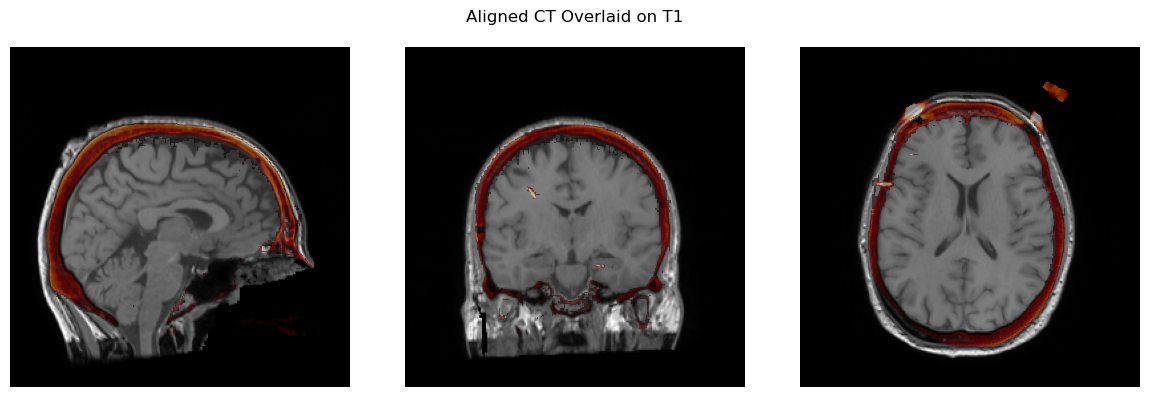

In [8]:
# 4X4 MATRIX


reg_affine = np.array([
    [0.99270756, -0.03243313, 0.11610254, -133.094156],
    [0.04374389, 0.99439665, -0.09623816, -97.58320673],
    [-0.11233068, 0.10061512, 0.98856381, -84.45551601],
    [0., 0., 0., 1.]])
# use a cval='1%' here to make the values outside the domain of the CT
# the same as the background level during interpolation
CT_aligned = mne.transforms.apply_volume_registration(
    CT_orig, T1, reg_affine, cval='1%')
plot_overlay(T1, CT_aligned, 'Aligned CT Overlaid on T1', thresh=0.95)
del CT_orig

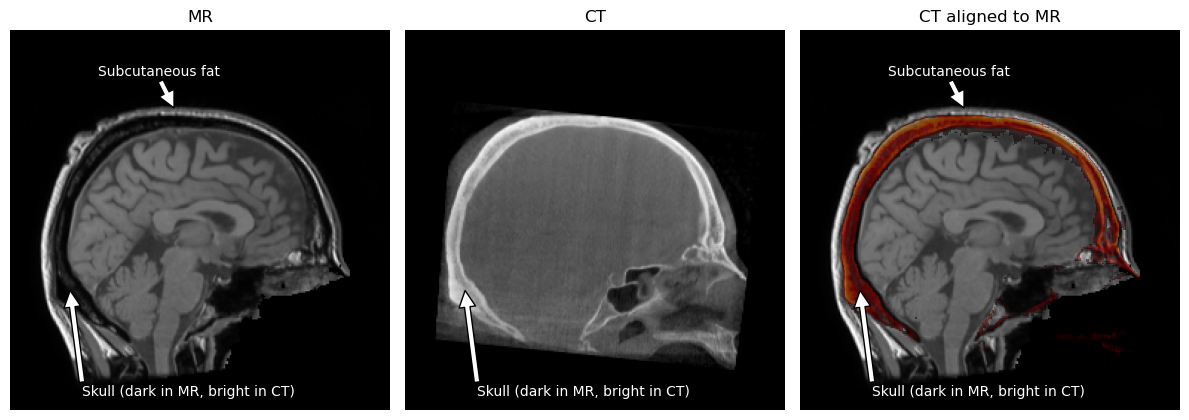

In [9]:
# make low intensity parts of the CT transparent for easier visualization
CT_data = CT_aligned.get_fdata().copy()
CT_data[CT_data < np.quantile(CT_data, 0.95)] = np.nan
T1_data = np.asarray(T1.dataobj)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
for ax in axes:
    ax.axis('off')
axes[0].imshow(T1_data[T1.shape[0] // 2], cmap='gray')
axes[0].set_title('MR')
axes[1].imshow(np.asarray(CT_aligned.dataobj)[CT_aligned.shape[0] // 2],
               cmap='gray')
axes[1].set_title('CT')
axes[2].imshow(T1_data[T1.shape[0] // 2], cmap='gray')
axes[2].imshow(CT_data[CT_aligned.shape[0] // 2], cmap='gist_heat', alpha=0.5)
for ax in (axes[0], axes[2]):
    ax.annotate('Subcutaneous fat', (110, 52), xytext=(100, 30),
                color='white', horizontalalignment='center',
                arrowprops=dict(facecolor='white'))
for ax in axes:
    ax.annotate('Skull (dark in MR, bright in CT)', (40, 175),
                xytext=(120, 246), horizontalalignment='center',
                color='white', arrowprops=dict(facecolor='white'))
axes[2].set_title('CT aligned to MR')
fig.tight_layout()
del CT_data, T1

In [10]:
# estimate head->mri transform
subj_trans = mne.coreg.estimate_head_mri_t(
    'sample_seeg', misc_path / 'seeg')

marking the location of each electrode contract

In [11]:
# load electrophysiology data to find channel locations for
# (the channels are already located in the example)

raw = mne.io.read_raw(misc_path / 'seeg' / 'sample_seeg_ieeg.fif')

# you may want to add `block=True` to halt execution until you have interacted
# with the GUI to find the channel positions, that way the raw object can
# be used later in the script (e.g. saved with channel positions)
mne.gui.locate_ieeg(raw.info, subj_trans, CT_aligned,
                    subject='sample_seeg',
                    subjects_dir=misc_path / 'seeg')
# The `raw` object is modified to contain the channel locations

Opening raw data file /Users/DanDan/mne_data/MNE-misc-data/seeg/sample_seeg_ieeg.fif...
    Range : 1310640 ... 1370605 =   1311.411 ...  1371.411 secs
Ready.
Loading /Users/DanDan/mne_data/MNE-misc-data/seeg/sample_seeg/mri/brain.mgz
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


qt.qpa.window: <QNSWindow: 0x7fbe00347e50; contentView=<QNSView: 0x7fbdf6bac220; QCocoaWindow(0x7fbdf6bb0080, window=QWidgetWindow(0x7fbdf5ff1150, name="QWidgetClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fbdf63d6e80; contentView=<QNSView: 0x7fbdf63d70a0; QCocoaWindow(0x7fbdf63d42a0, window=QWidgetWindow(0x7fbdf63d7c30, name="QWidgetClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


In [12]:
T1_ecog = nib.load(misc_path / 'ecog' / 'sample_ecog' / 'mri' / 'T1.mgz')
CT_orig_ecog = nib.load(misc_path / 'ecog' / 'sample_ecog_CT.mgz')

# pre-computed affine from `mne.transforms.compute_volume_registration`
reg_affine = np.array([
    [0.99982382, -0.00414586, -0.01830679, 0.15413965],
    [0.00549597, 0.99721885, 0.07432601, -1.54316131],
    [0.01794773, -0.07441352, 0.99706595, -1.84162514],
    [0., 0., 0., 1.]])
# align CT
CT_aligned_ecog = mne.transforms.apply_volume_registration(
    CT_orig_ecog, T1_ecog, reg_affine, cval='1%')

raw_ecog = mne.io.read_raw(misc_path / 'ecog' / 'sample_ecog_ieeg.fif')
# use estimated `trans` which was used when the locations were found previously
subj_trans_ecog = mne.coreg.estimate_head_mri_t(
    'sample_ecog', misc_path / 'ecog')
mne.gui.locate_ieeg(raw_ecog.info, subj_trans_ecog, CT_aligned_ecog,
                    subject='sample_ecog',
                    subjects_dir=misc_path / 'ecog')

Applying affine registration ...
Using a lower bound at the 1.0 percentile: -3024.0
[done]
Opening raw data file /Users/DanDan/mne_data/MNE-misc-data/ecog/sample_ecog_ieeg.fif...
    Range : 0 ... 112 =      0.000 ...     0.700 secs
Ready.
Loading /Users/DanDan/mne_data/MNE-misc-data/ecog/sample_ecog/mri/brain.mgz
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


qt.qpa.window: <QNSWindow: 0x7fbe0e9646d0; contentView=<QNSView: 0x7fbdfd7ac860; QCocoaWindow(0x7fbdfd7abf50, window=QWidgetWindow(0x7fbdfd7a2100, name="QWidgetClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fbe01919660; contentView=<QNSView: 0x7fbdfd7ba630; QCocoaWindow(0x7fbdfd7bac30, window=QWidgetWindow(0x7fbdfd7b98b0, name="QWidgetClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


In [13]:
# plot projected sensors
brain_kwargs = dict(cortex='low_contrast', alpha=0.2, background='white')
brain = mne.viz.Brain('sample_ecog', subjects_dir=misc_path / 'ecog',
                      title='Before Projection', **brain_kwargs)
brain.add_sensors(raw_ecog.info, trans=subj_trans_ecog)
view_kwargs = dict(azimuth=60, elevation=100, distance=350,
                   focalpoint=(0, 0, -15))
brain.show_view(**view_kwargs)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	ecog: 320, seeg: 74
Clicked Y (1) axis at pos (81.92031434934195, 107.39573069745217)
Clicked Y (1) axis at pos (97.28031434934195, 63.72514246215805)
Clicked Y (1) axis at pos (150.18698101600862, 44.14867187392275)
Saving channel positions to `info`
Saving channel positions to `info`
Saving channel positions to `info`
